# Import required libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Data Loading and Cleaning

We load the Kepler cumulative catalog, select relevant features, and handle missing values.


In [21]:
try:
    kepler_df = pd.read_csv('../data/cumulative.csv')
except FileNotFoundError:
    print("Error: cumulative.csv not found. Please make sure the file is in the correct directory.")
    exit()

# Select relevant features
features = [
    'koi_period', 'koi_time0bk', 'koi_impact', 'koi_prad', 'koi_teq',
    'koi_srad', 'koi_steff', 'koi_depth', 'koi_model_snr'
]
kepler_data = kepler_df[features].copy()

# Replace missing values with median
kepler_data.fillna(kepler_data.median(), inplace=True)

## Feature Scaling

Clustering algorithms perform best when features are scaled. Here, we standardize all features to zero mean and unit variance.


In [22]:
scaler = StandardScaler()
scaled_kepler = scaler.fit_transform(kepler_data)
scaled_kepler_df = pd.DataFrame(scaled_kepler, columns=features)


## Astrophysical Naming Rule

A simple heuristic to label clusters based on median exoplanet characteristics.


In [23]:
def name_cluster(row):
    p = row.get('koi_period',    row.get('koi_period_median'))
    r = row.get('koi_prad',      row.get('koi_prad_median'))
    t = row.get('koi_teq',       row.get('koi_teq_median'))
    if (p < 10) and (r > 5):
        return "Hot Jupiters"
    elif (r < 2) and (t < 500):
        return "Earth‑like"
    else:
        return "Neptunes / Sub‑Neptunes"


## Unified Clustering Framework

A utility function to apply various clustering algorithms, evaluate their silhouette scores, and prioritize astrophysical interpretability.


In [24]:
def perform_clustering(data, Algorithm, param_grid, name):
    print(f"\n--- {name} ---")
    best_model      = None
    best_params     = None
    best_silhouette = -1
    best_unique     = 0

    for params in ParameterGrid(param_grid):
        if name == "KMeans" and params.get('n_clusters', 3) < 3:
            continue

        kwargs = params.copy()
        if 'random_state' in Algorithm().get_params():
            kwargs['random_state'] = 42
        model = Algorithm(**kwargs)

        if name == 'GaussianMixture':
            model.fit(data)
            labels = model.predict(data)
        else:
            labels = model.fit_predict(data)

        n_clusters = len(set(labels) - {-1})
        if n_clusters < 1:
            continue

        sil = silhouette_score(data, labels) if len(set(labels)) > 1 else -1

        if name == "KMeans":
            if sil > best_silhouette:
                best_silhouette = sil
                best_model      = model
                best_params     = params
        else:
            temp = kepler_data.copy()
            temp['cluster'] = labels
            med  = temp.groupby('cluster').median()
            unique_names = med.apply(name_cluster, axis=1).nunique()

            if unique_names < 3:
                continue

            if (unique_names > best_unique) or \
               (unique_names == best_unique and sil > best_silhouette):
                best_unique     = unique_names
                best_silhouette = sil
                best_model      = model
                best_params     = params

    if best_model is None:
        print(f"No {name} params yielded the required clusters.")
        return None, None, None

    print("Best params:", best_params)
    if name == "KMeans":
        print(f"Silhouette Score: {best_silhouette:.4f}")
    else:
        print(f"Distinct astrophysical labels: {best_unique}")
        print(f"Silhouette Score: {best_silhouette:.4f}")

    return best_model, best_params, best_silhouette


## Hyperparameter Grids

Define search spaces for each clustering algorithm.


In [25]:
kmeans_params = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}
dbscan_params = {
    'eps': np.arange(0.1, 1.0, 0.1),
    'min_samples': range(5, 20)
}
agg_params = {
    'n_clusters': range(2, 11),
    'linkage': ['ward', 'complete', 'average']
}
gmm_params = {
    'n_components': range(2, 11),
    'covariance_type': ['full', 'tied', 'diag'],
    'max_iter': [100, 200],
    'n_init': [1, 3]
}


## Run Clustering Algorithms

Execute all four clustering algorithms and select the best model.


In [26]:
results = {
    'KMeans':          perform_clustering(scaled_kepler_df, KMeans,              kmeans_params, "KMeans"),
    'DBSCAN':          perform_clustering(scaled_kepler_df, DBSCAN,            dbscan_params, "DBSCAN"),
    'Agglomerative':   perform_clustering(scaled_kepler_df, AgglomerativeClustering, agg_params, "AgglomerativeClustering"),
    'GaussianMixture': perform_clustering(scaled_kepler_df, GaussianMixture,    gmm_params,   "GaussianMixture")
}



--- KMeans ---
Best params: {'init': 'random', 'n_clusters': 3, 'n_init': 20}
Silhouette Score: 0.6368

--- DBSCAN ---
Best params: {'eps': 0.5, 'min_samples': 8}
Distinct astrophysical labels: 3
Silhouette Score: 0.3711

--- AgglomerativeClustering ---
No AgglomerativeClustering params yielded the required clusters.

--- GaussianMixture ---
Best params: {'covariance_type': 'tied', 'max_iter': 100, 'n_components': 10, 'n_init': 1}
Distinct astrophysical labels: 3
Silhouette Score: 0.4068


## Visualize Clusters using t-SNE

Project the high-dimensional data into 2D for human-friendly visualization.


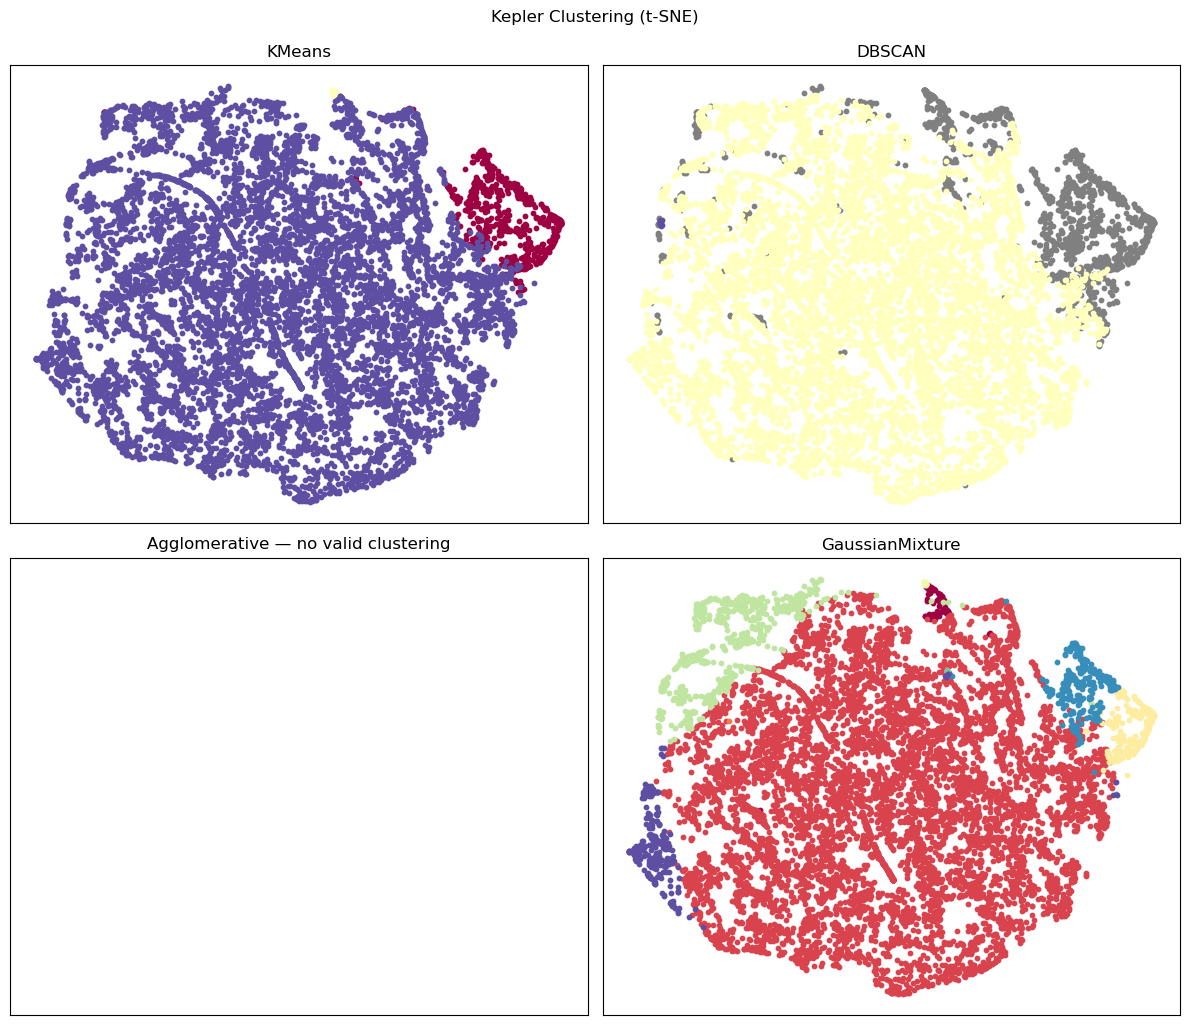

In [27]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_kepler_df)

plt.figure(figsize=(12, 10))
for i, (name, (model, params, score)) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    if model is not None:
        labels = (model.predict(scaled_kepler_df)
                  if name=='GaussianMixture'
                  else model.fit_predict(scaled_kepler_df))

        uniq = np.unique(labels)
        cols = plt.cm.Spectral(np.linspace(0,1,len(uniq)))
        for k, c in zip(uniq, cols):
            mask = labels==k
            xy   = tsne_result[mask]
            if k==-1:
                plt.scatter(xy[:,0], xy[:,1], s=10, c='gray', label='noise')
            else:
                plt.scatter(xy[:,0], xy[:,1], s=10, c=[c], label=f'cluster {k}')
        plt.title(name)
    else:
        plt.title(f"{name} — no valid clustering")
    plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.suptitle("Kepler Clustering (t-SNE)", y=1.02)
plt.show()


## Clustering Summary

Review the performance of each algorithm.


In [28]:
print("\n--- Clustering Summary ---")
for name, (model, params, score) in results.items():
    if model is None:
        print(f"{name}: failed to produce the required clusters.")
    else:
        if score is not None:
            print(f"{name}: Silhouette = {score:.4f}, Params = {params}")
        else:
            print(f"{name}: Params = {params}")



--- Clustering Summary ---
KMeans: Silhouette = 0.6368, Params = {'init': 'random', 'n_clusters': 3, 'n_init': 20}
DBSCAN: Silhouette = 0.3711, Params = {'eps': 0.5, 'min_samples': 8}
Agglomerative: failed to produce the required clusters.
GaussianMixture: Silhouette = 0.4068, Params = {'covariance_type': 'tied', 'max_iter': 100, 'n_components': 10, 'n_init': 1}


## Downstream Analysis

Select the best clustering result for interpretation and apply astrophysical labels.


In [29]:
chosen_name, (chosen_model, _, _) = next(
    ((n,r) for n,r in results.items() if r[0] is not None),
    (None,(None,None,None))
)

if chosen_model is None:
    print("No valid clustering for further analysis.")
    exit()

print(f"\nUsing {chosen_name} for further analysis.")
labels = (chosen_model.predict(scaled_kepler_df)
          if chosen_name=='GaussianMixture'
          else chosen_model.fit_predict(scaled_kepler_df))



Using KMeans for further analysis.


## Cluster Statistics

Show statistical summaries and heuristic labels for each cluster.


In [30]:
kepler_labeled = kepler_data.copy()
kepler_labeled['cluster'] = labels

if chosen_name=='KMeans':
    centers_scaled = chosen_model.cluster_centers_
    centers_orig   = scaler.inverse_transform(centers_scaled)
    df_centers     = pd.DataFrame(centers_orig, columns=features)
    df_centers['cluster'] = df_centers.index
    print("\nKMeans centroids (orig scale):")
    print(df_centers.round(2))

summary = kepler_labeled.groupby('cluster').agg({
    'koi_period':    ['count','median'],
    'koi_prad':      ['median'],
    'koi_teq':       ['median'],
    'koi_model_snr':['median']
})
summary.columns = ['_'.join(c) for c in summary.columns]
print("\nCluster summary (counts & medians):")
print(summary)

summary['label'] = summary.apply(name_cluster, axis=1)
print("\nCluster labels:")
print(summary['label'])



KMeans centroids (orig scale):
   koi_period  koi_time0bk  koi_impact  koi_prad  koi_teq  koi_srad  \
0       34.76       154.43        2.67   1278.27  1287.24      1.49   
1       48.41       152.17        0.42    607.75  6842.25     95.23   
2       78.60       167.04        0.59     15.62  1044.85      1.42   

   koi_steff  koi_depth  koi_model_snr  cluster  
0    6096.25  269626.32        2468.51        0  
1    3744.46     395.29          27.56        1  
2    5688.40    5848.06          97.66        2  

Cluster summary (counts & medians):
         koi_period_count  koi_period_median  koi_prad_median  koi_teq_median  \
cluster                                                                         
0                     619           7.226944            67.96          1106.0   
1                      28           3.959522           123.53          6712.0   
2                    8917          10.004688             2.32           878.0   

         koi_model_snr_median  
cluster 